# Final Project : predict sentiment of a tweet
## Victor Bordier 72248, Cassie Doguet 72270, Solène Le Cardinal 72246
### 21/05/2023

# Importations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.regularizers import l2

import matplotlib.pyplot as plt

import re

from nltk.stem import PorterStemmer

import warnings 
%matplotlib inline

from wordcloud import WordCloud

warnings.filterwarnings('ignore')

### Load the data

In [2]:
df = pd.read_csv('Tweets.csv')
df.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

# Preprocessing the data
We want to optimize the data of the selected_text

### Removing the ponctuation except for * and !

In [3]:
def remove_ponctuations(text):
    text = str(text)
    text_without_ponctuations = re.sub(r'[^\w\s*!]', '', text)
    return text_without_ponctuations

df['selected_text'] = df['selected_text'].apply(remove_ponctuations)
df.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                       selected_text sentiment  
0  Id have responded if I were going   neutral  
1                           Sooo SAD  negative  
2                        bullying me  negative  
3                     leave me alone  negative  
4                       Sons of ****  negative

### Tokenize the 'selected_text' column

In [4]:
tokenized_tweet = df['selected_text'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [Id, have, responded, if, I, were, going]
1                                  [Sooo, SAD]
2                               [bullying, me]
3                           [leave, me, alone]
4                             [Sons, of, ****]
Name: selected_text, dtype: object

### Apply stemming to the tokenized text

In [5]:
stemmer = PorterStemmer()
 
# Apply stemming to the tokenized text
tokenized_tweet = tokenized_tweet.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
tokenized_tweet.head()

0    [id, have, respond, if, i, were, go]
1                             [sooo, sad]
2                             [bulli, me]
3                        [leav, me, alon]
4                         [son, of, ****]
Name: selected_text, dtype: object

### Joining all words from the processed tweets

In [6]:
for i in range(0, len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])
 
df['selected_text'] = tokenized_tweet
 
df.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                  selected_text sentiment  
0  id have respond if i were go   neutral  
1                      sooo sad  negative  
2                      bulli me  negative  
3                  leav me alon  negative  
4                   son of ****  negative

# Exploratory data analysis

In [7]:
def plot_the_most_used_words_based_on_sentiment(code,color) : 
    all_words = " ".join([sentence for sentence in df['selected_text'][df['sentiment']==code]])
    couleur_rose = color

    wordcloud = WordCloud(width=800,height=500,background_color='white',colormap='Pastel1', color_func=lambda *args, **kwargs: couleur_rose,random_state = 42,max_font_size = 100).generate(all_words)

    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

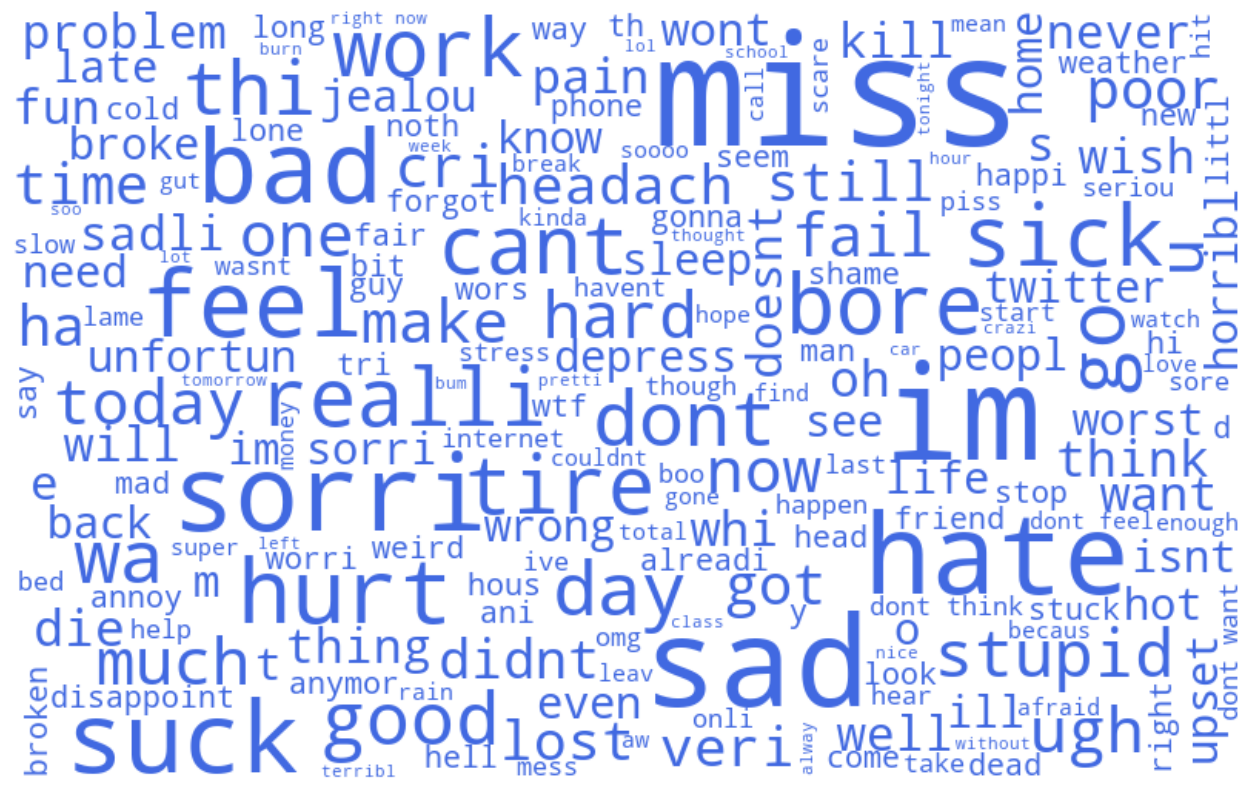

In [8]:
plot_the_most_used_words_based_on_sentiment('negative',"#4169E1")

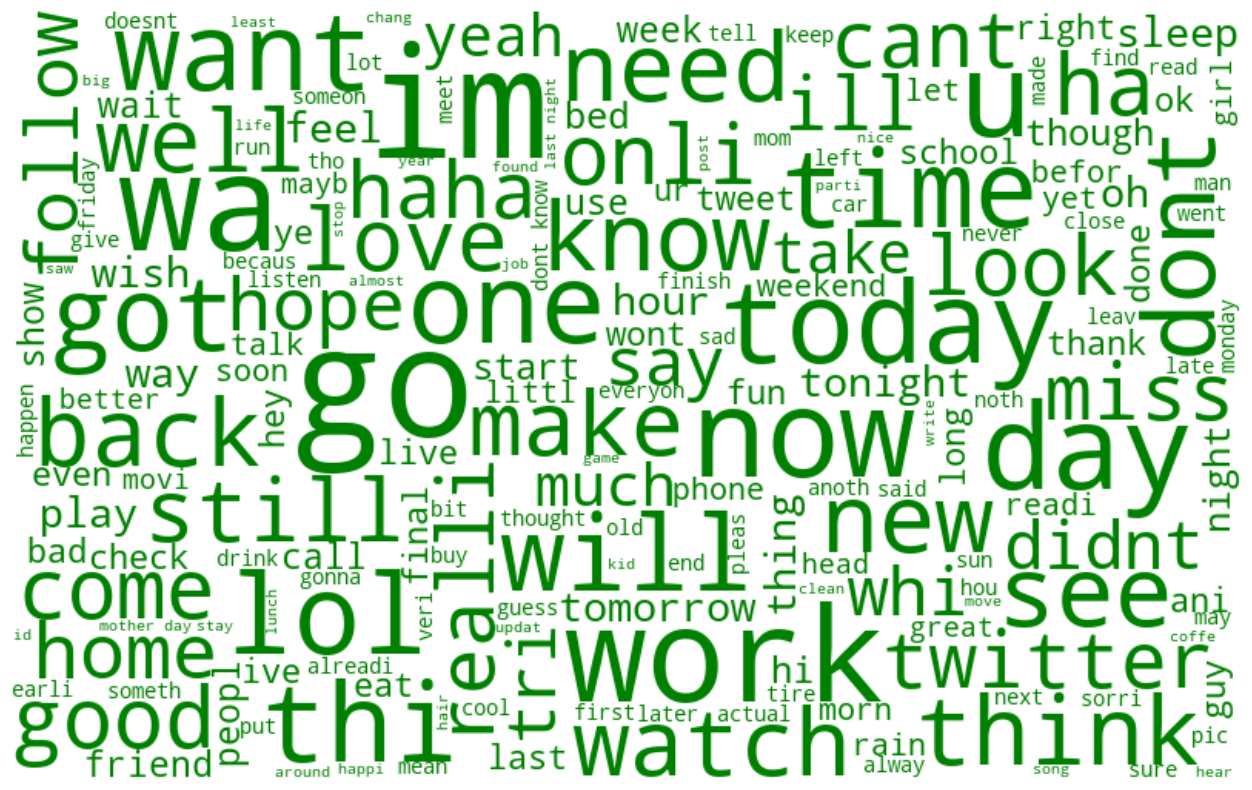

In [9]:
plot_the_most_used_words_based_on_sentiment('neutral',"#008000")

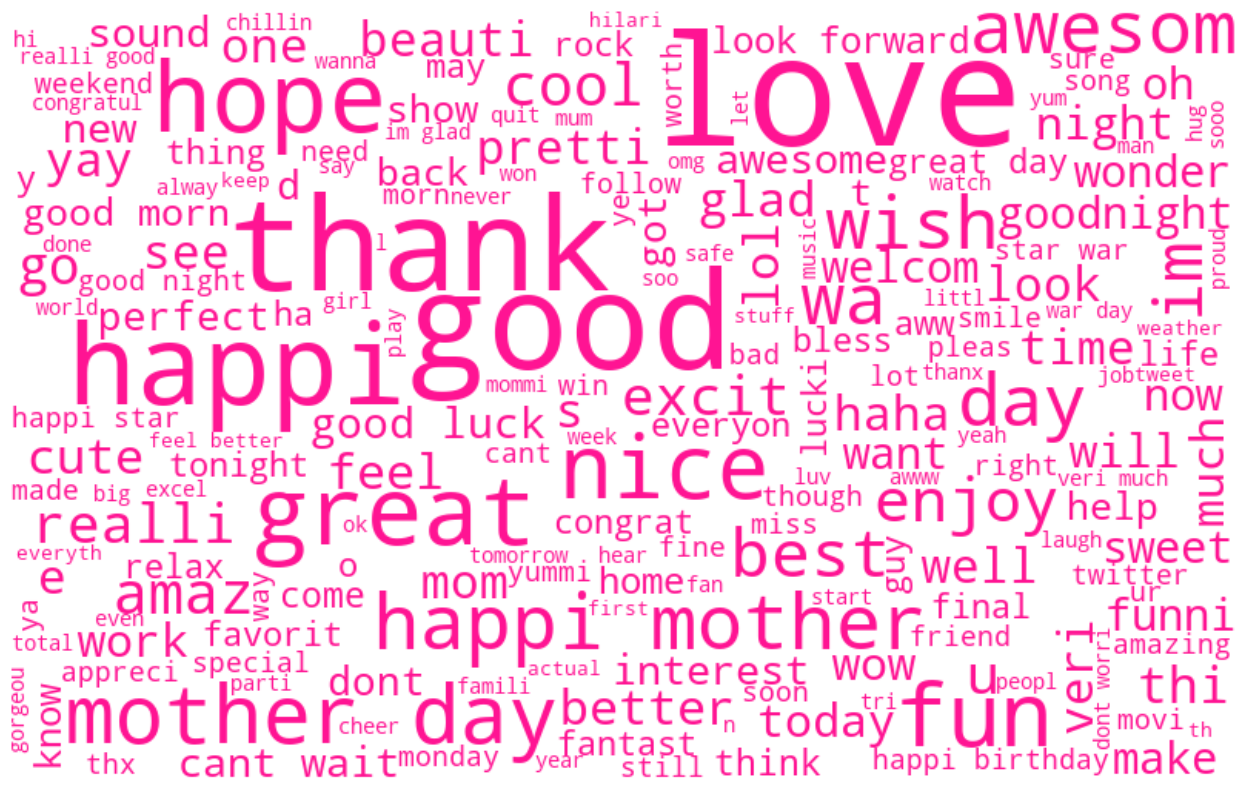

In [10]:
plot_the_most_used_words_based_on_sentiment('positive',"#FF1493")

# Spliting the data

In [11]:
max_features = 5000
 
# Tokenize and pad the text
tokenizer = Tokenizer(num_words=max_features, oov_token='OOV', filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~')
tokenizer.fit_on_texts(df['selected_text'].values)
features = tokenizer.texts_to_sequences(df['selected_text'].values)
features = pad_sequences(features, padding='post')

In [12]:
# Convert sentiment labels to numerical data
labels = pd.get_dummies(df['sentiment']).values
X_train, X_val, Y_train, Y_val = train_test_split(features, labels, test_size=0.33, random_state=42)
print("Input training features and label shape are {},{}".format(X_train.shape, Y_train.shape))
print("Input validation features and label shape are {},{}".format(X_val.shape, Y_val.shape))

Input training features and label shape are (18412, 33),(18412, 3)
Input validation features and label shape are (9069, 33),(9069, 3)


# Building the model

In [13]:
embedding_dimension = 128
 
# Build and compile the LSTM model
LSTM_model = Sequential()
LSTM_model.add(Embedding(max_features, embedding_dimension, input_length=features.shape[1]))
LSTM_model.add(SpatialDropout1D(0.4))
LSTM_model.add(LSTM(128, kernel_regularizer=l2(0.1), dropout=0.4, recurrent_dropout=0.4))
LSTM_model.add(Dense(3, activation='softmax'))
LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 128)           640000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 33, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 771,971
Trainable params: 771,971
Non-trainable params: 0
_________________________________________________________________


# Training the model

In [14]:
batch_size = 256
 
# Train the LSTM model
LSTM_model_history = LSTM_model.fit(X_train, Y_train, epochs=8, batch_size=batch_size, verbose=1, shuffle=True, validation_data=(X_val, Y_val))

Epoch 1/8
72/72 [==============================] - 29s 329ms/step - loss: 8.4230 - accuracy: 0.5160 - val_loss: 1.9786 - val_accuracy: 0.6282
Epoch 2/8
72/72 [==============================] - 31s 438ms/step - loss: 1.0797 - accuracy: 0.6579 - val_loss: 0.7397 - val_accuracy: 0.6801
Epoch 3/8
72/72 [==============================] - 35s 487ms/step - loss: 0.6234 - accuracy: 0.7636 - val_loss: 0.5760 - val_accuracy: 0.7890
Epoch 4/8
72/72 [==============================] - 24s 327ms/step - loss: 0.5250 - accuracy: 0.8103 - val_loss: 0.5421 - val_accuracy: 0.8048
Epoch 5/8
72/72 [==============================] - 22s 313ms/step - loss: 0.4707 - accuracy: 0.8357 - val_loss: 0.5241 - val_accuracy: 0.8175
Epoch 6/8
72/72 [==============================] - 24s 335ms/step - loss: 0.4329 - accuracy: 0.8528 - val_loss: 0.5362 - val_accuracy: 0.8148
Epoch 7/8
72/72 [==============================] - 23s 326ms/step - loss: 0.4164 - accuracy: 0.8569 - val_loss: 0.5136 - val_accuracy: 0.8191
Epoch 

# Evaluate the model

In [15]:
loss, accuracy = LSTM_model.evaluate(X_val, Y_val, verbose=1)
 
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

284/284 [==============================] - 8s 29ms/step - loss: 0.5304 - accuracy: 0.8099
Validation Loss: 0.5303733348846436
Validation Accuracy: 0.8099018931388855


# You can also test it :)

In [16]:
tweet = "I don't like my neighboor" 
# Somes ideas : I love my mom / I hate politics / I do my IA project / I drink water / Shut up / She is so perfect and nice / I don't like my neighboor

### Preprocess the tweet

In [17]:
# Preprocess the tweet (remove all the ponctuation exept * and !)
preprocessed_tweet = re.sub(r'[^\w\s*!]', '', tweet.lower())

# Tokenize and pad the preprocessed tweet
tokenized_tweet = tokenizer.texts_to_sequences([preprocessed_tweet])
padded_tweet = pad_sequences(tokenized_tweet, padding='post', maxlen=features.shape[1])

### Make the prediction and convert it to sentiment label

In [18]:
# Predict the sentiment
lstm_prediction = LSTM_model.predict(padded_tweet)

# Convert the prediction to sentiment label
lstm_sentiment = np.argmax(lstm_prediction, axis=1)

confidence = np.max(lstm_prediction) * 100

1/1 [==============================] - 1s 975ms/step


In [19]:
if lstm_sentiment == 2 : 
    print("Positive with", round(confidence,2), "% confidence")
elif lstm_sentiment == 0 : 
    print("Negative with", round(confidence,2), "% confidence")
else :
    print("Neutral with", round(confidence,2), "% confidence")

Negative with 53.23 % confidence
